Understanding the Data (Transforms and Analysis)

Fourier Transform: We apply the Fourier Transform to analyze the frequency components of the seismic signals, allowing us to identify dominant frequency ranges that correlate with seismic events.
Wavelet Transform: Wavelet analysis provides time-frequency localization, helping us detect transient seismic events more accurately and understand their evolution over time.


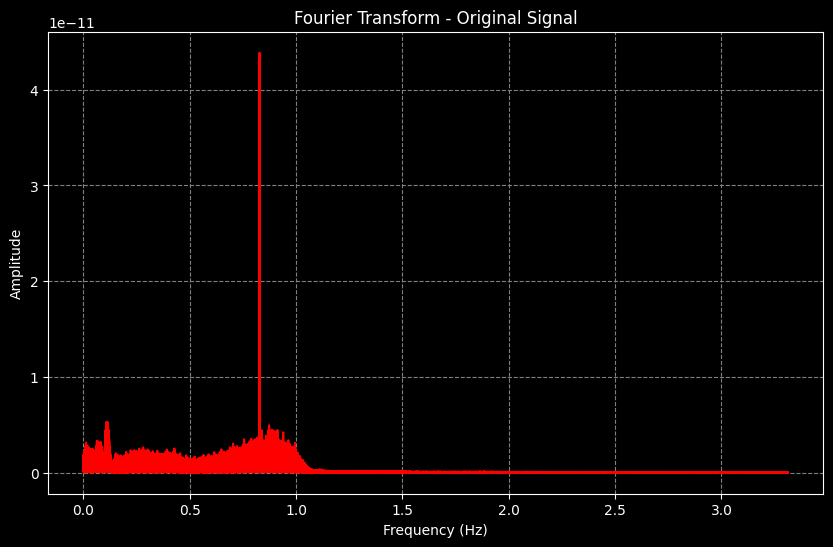

/home/jamal/Documents/nasa/nasa_test/lib/python3.12/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


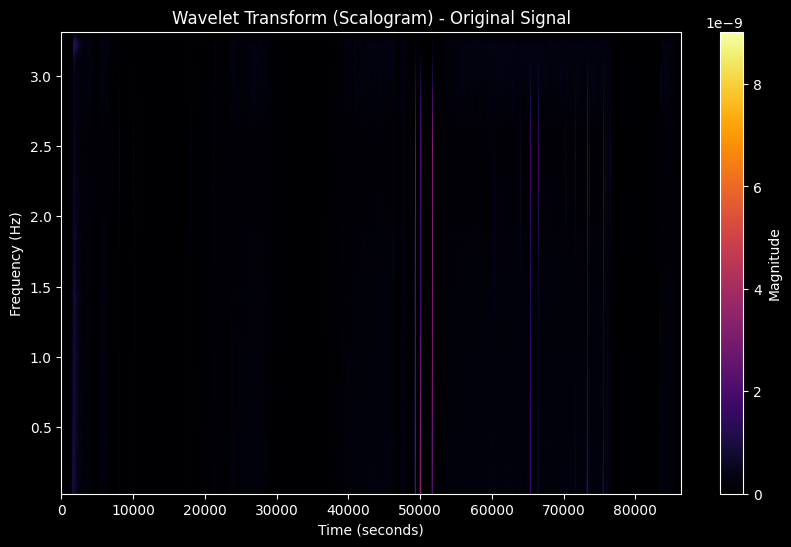

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from scipy.fft import fft, fftfreq
import pywt  # For wavelet transform

# Function to plot the Fourier Transform
def plot_fourier_transform(data, sampling_rate, title):
    # Compute the Fourier Transform
    N = len(data)
    T = 1.0 / sampling_rate
    yf = fft(data)
    xf = fftfreq(N, T)[:N // 2]

    # Plot the result
    plt.figure(figsize=(10, 6))
    plt.style.use('dark_background')
    plt.plot(xf, 2.0 / N * np.abs(yf[:N // 2]), color='red')
    plt.title(f'Fourier Transform - {title}', color='white')
    plt.xlabel('Frequency (Hz)', color='white')
    plt.ylabel('Amplitude', color='white')
    plt.grid(True, linestyle='--', color='gray')
    plt.show()

# Function to plot the Continuous Wavelet Transform (CWT)
def plot_wavelet_transform(data, sampling_rate, title):
    # Perform Continuous Wavelet Transform (CWT) using 'cmor' wavelet (complex morlet)
    scales = np.arange(1, 128)
    wavelet = 'cmor'
    coef, freqs = pywt.cwt(data, scales, wavelet, 1.0 / sampling_rate)

    # Plot the result as a scalogram
    plt.figure(figsize=(10, 6))
    plt.style.use('dark_background')
    plt.imshow(np.abs(coef), extent=[0, len(data) / sampling_rate, freqs[-1], freqs[0]], cmap='inferno', aspect='auto')
    plt.colorbar(label='Magnitude')
    plt.title(f'Wavelet Transform (Scalogram) - {title}', color='white')
    plt.xlabel('Time (seconds)', color='white')
    plt.ylabel('Frequency (Hz)', color='white')
    plt.grid(False)
    plt.show()

# Load the seismic data
mseed_file = 'space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed'  # Replace with the actual path
st = read(mseed_file)
sampling_rate = st[0].stats.sampling_rate  # Sampling rate of the data
original_signal = st[0].data

# Plot Fourier Transform of the original signal
plot_fourier_transform(original_signal, sampling_rate, 'Original Signal')

# Plot Wavelet Transform (Scalogram) of the original signal
plot_wavelet_transform(original_signal, sampling_rate, 'Original Signal')


Applying Filters

Bandpass Filter: After identifying the relevant frequency ranges, a bandpass filter is applied to remove noise outside the target frequencies (e.g., 0.6–1.0 Hz), focusing on the seismic event’s dominant frequency range. This step improves the signal-to-noise ratio and enhances the quality of the seismic data.

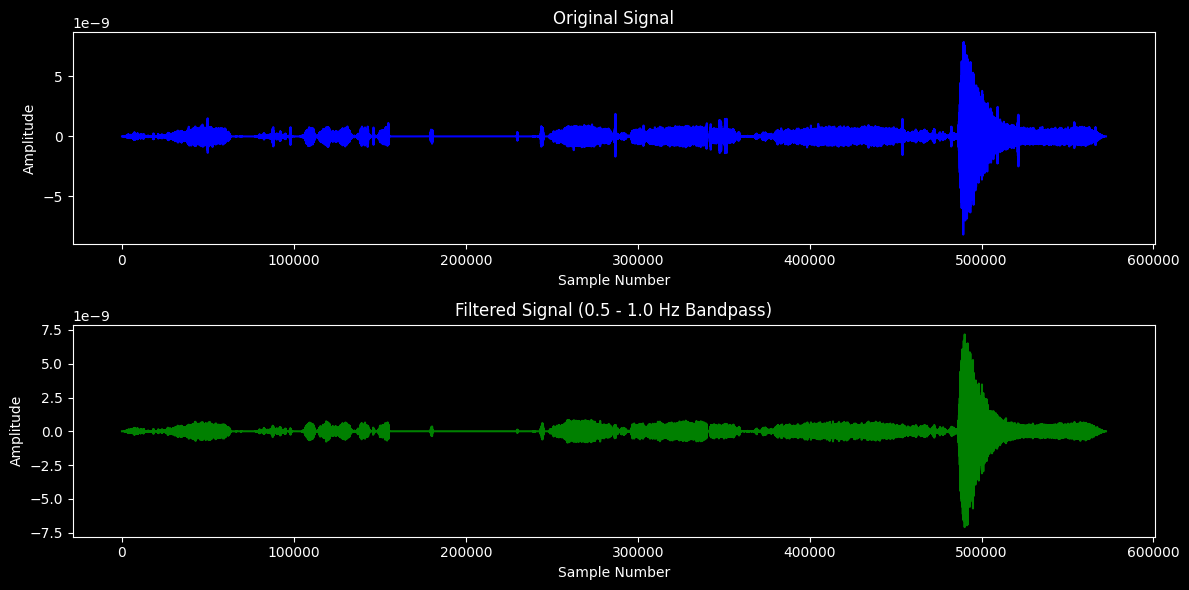

In [5]:
import numpy as np
from obspy import read
import matplotlib.pyplot as plt

# Function to apply a bandpass filter between 0.5 and 1.0 Hz
def bandpass_filter(tr, freqmin=0.7, freqmax=0.9):
    return tr.filter('bandpass', freqmin=freqmin, freqmax=freqmax)

# Function to plot original and filtered signals
def plot_signals(original_velocity, filtered_velocity):
    plt.figure(figsize=(12, 6))
    
    # Plot original signal
    plt.subplot(2, 1, 1)
    plt.plot(original_velocity, color='blue')
    plt.title('Original Signal')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')
    
    # Plot filtered signal
    plt.subplot(2, 1, 2)
    plt.plot(filtered_velocity, color='green')
    plt.title('Filtered Signal (0.5 - 1.0 Hz Bandpass)')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

# Main code
def main():
    # Path to your mseed file
    mseed_file = 'space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed'  # Replace with your actual mseed file path
    
    # Read the mseed file
    st = read(mseed_file)
    tr = st[0]
    
    # Get the original velocity data
    original_velocity = tr.data.copy()
    
    # Apply the bandpass filter
    tr_filtered = bandpass_filter(tr.copy(), freqmin=0.5, freqmax=1.0)
    filtered_velocity = tr_filtered.data
    
    # Plot the signals
    plot_signals(original_velocity, filtered_velocity)

if __name__ == "__main__":
    main()


Windowing and Feature Extraction for Model Training

Windowing: The filtered seismic signal is divided into fixed-size windows (e.g., 60 seconds), where each window represents a sequence of seismic measurements. This allows us to capture local temporal patterns related to seismic events.
Feature Extraction: From each window, features such as velocity mean, variance, and standard deviation are computed to describe the characteristics of the seismic data. These features are then used to train the model.
Training the Model (XGBoost)

Model Training: Using the extracted features from both event and non-event windows, the XGBoost model is trained to classify windows as either containing a seismic event or not. The model is designed to handle imbalanced data and efficiently learns from complex patterns in the seismic signal.
Cross-Validation: To ensure model robustness, cross-validation is performed during training to prevent overfitting and to validate the model's performance across different folds of the data.

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Load the CSV file with the windowed features
data = pd.read_csv('seismic_windows_with_features_2.csv')

# Split features and labels
X = data[['velocity_mean', 'velocity_std', 'velocity_max', 'velocity_min', 'velocity_variance']]
y = data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Function to evaluate a model using cross-validation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1, cv_scores

# Initialize the models
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)

# Evaluate Random Forest
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_cv_scores = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

# Evaluate XGBoost
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_cv_scores = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

# Compare Results
results = pd.DataFrame({
    'Method': ['Random Forest', 'XGBoost'],
    'Accuracy': [rf_accuracy, xgb_accuracy],
    'Precision': [rf_precision, xgb_precision],
    'Recall': [rf_recall, xgb_recall],
    'F1 Score': [rf_f1, xgb_f1]
})

print(results)
print("\nCross-validation scores (Random Forest):", rf_cv_scores)
print("Mean cross-validation accuracy (Random Forest):", np.mean(rf_cv_scores))

print("\nCross-validation scores (XGBoost):", xgb_cv_scores)
print("Mean cross-validation accuracy (XGBoost):", np.mean(xgb_cv_scores))

# Classification reports for each model
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_model.predict(X_test)))
import joblib
import xgboost as xgb
joblib.dump(xgb_model, 'xgb_model.pkl')

print("Model saved to 'xgb_model.pkl'")


          Method  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.666667   1.000000  0.000000  0.000000
1        XGBoost  0.881481   0.784314  0.888889  0.833333

Cross-validation scores (Random Forest): [0.66666667 0.66666667 0.66666667 0.33333333 0.66666667]
Mean cross-validation accuracy (Random Forest): 0.6

Cross-validation scores (XGBoost): [0.85079365 0.85714286 0.84761905 0.86984127 0.85714286]
Mean cross-validation accuracy (XGBoost): 0.8565079365079364

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       450
           1       0.00      0.00      0.00       225

    accuracy                           0.67       675
   macro avg       0.33      0.50      0.40       675
weighted avg       0.44      0.67      0.53       675


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       450
           1   

/home/jamal/Documents/nasa/nasa_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jamal/Documents/nasa/nasa_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jamal/Documents/nasa/nasa_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Predicting Seismic Events

Prediction: The trained XGBoost model is used to predict seismic events in new data by applying it to each window in the seismic signal. The predictions are made in real-time, where each minute of data is classified as an event (1) or non-event (0).
Post-Processing: The prediction results are grouped by minute for interpretation, and any window containing an event is labeled as an event for the entire minute to ensure accurate reporting.

In [ ]:
import os
import pandas as pd
import numpy as np
from obspy import read, UTCDateTime
import xgboost as xgb
import joblib  # To load your pre-trained XGBoost model
from scipy.ndimage import uniform_filter1d  # For simple moving average
import json

# Function to filter the data with a narrower bandwidth
def bandpass_filter(tr, freqmin=0.8, freqmax=0.9):  # Adjusted bandwidth
    return tr.filter('bandpass', freqmin=freqmin, freqmax=freqmax)

# Function to calculate features from a window
def calculate_features(window_data):
    return {
        "velocity_mean": np.mean(window_data),
        "velocity_std": np.std(window_data),
        "velocity_max": np.max(window_data),
        "velocity_min": np.min(window_data),
        "velocity_variance": np.var(window_data)
    }

# Function to generate predictions for a single day (file) using the XGBoost model
def generate_predictions_for_day(model, mseed_file, window_size=60, freqmin=0.8, freqmax=0.9):
    data = []
    
    # Load the mseed file and filter it
    st = read(mseed_file)
    st_filtered = bandpass_filter(st[0], freqmin=freqmin, freqmax=freqmax)
    
    # Get the original and filtered velocities
    original_velocity = st[0].data
    filtered_velocity = st_filtered.data
    
    # Loop through the data and make predictions starting from the 60th second
    for i in range(len(original_velocity) - window_size):
        # Extract a sliding window of data (last 60 seconds)
        window_data = filtered_velocity[i:i+window_size]
        features = calculate_features(window_data)
        
        # Use the model to predict if there's an event (1) or no event (0)
        feature_array = np.array([features["velocity_mean"], features["velocity_std"], features["velocity_max"], features["velocity_min"], features["velocity_variance"]]).reshape(1, -1)
        prediction = model.predict(feature_array)[0]
        
        # Store the results
        data.append({
            "second": i + window_size,  # We start predicting after 60 seconds
            "original_velocity": original_velocity[i + window_size],
            "filtered_velocity": filtered_velocity[i + window_size],
            "prediction": prediction
        })
        
        # Print processing information
        print(f"Processed second: {i + window_size}")
    
    return pd.DataFrame(data)

# Function to group data by minute without averaging the prediction
def group_data_by_minute(df):
    df['timestamp'] = pd.to_datetime(df['second'], unit='s')  # Convert seconds to timestamp

    # Group by minute
    df['minute'] = df['timestamp'].dt.floor('T')  # Round down to the nearest minute
    grouped = df.groupby('minute').agg({
        'original_velocity': 'mean',  # Use mean of original velocity for each minute
        'filtered_velocity': 'mean',  # Use mean of filtered velocity for each minute
        'prediction': lambda x: 1 if (x == 1).any() else 0  # If any second in the minute has a 1, set prediction to 1, else 0
    }).reset_index()

    return grouped

# Function to export grouped data to JSON
def export_to_json(df, output_file):
    json_data = df.to_json(orient='records', date_format='iso')
    with open(output_file, 'w') as f:
        f.write(json_data)
    print(f"Data exported to {output_file}")

# Function to process a single mseed file and output results for the frontend
def process_single_day(mseed_file, model, output_csv="predictions_for_single_day.csv", output_json="predictions_for_single_day.json"):
    # Generate predictions for the day
    day_predictions = generate_predictions_for_day(model, mseed_file)
    
    # Group data by minute
    grouped_data = group_data_by_minute(day_predictions)
    
    # Save the grouped data to a CSV file
    grouped_data.to_csv(output_csv, index=False)
    print(f"Grouped predictions for the day saved to {output_csv}")
    
    # Export to JSON
    export_to_json(grouped_data, output_json)

# Example usage for a single day:
mseed_file = 'space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed'  # Replace with the actual path to your mseed file
output_csv = 'predictions_for_xa.s12.00.mhz.1969-12-16HR00_evid00006_grouped.csv'
output_json = 'predictions_for_xa.s12.00.mhz.1969-12-16HR00_evid00006_grouped.json'

# Load the pre-trained XGBoost model from file (replace 'xgb_model_path' with the actual path to your model)
xgb_model = joblib.load('xgb_model.pkl')

# Generate predictions for the single day file and group the results by minute
process_single_day(mseed_file, xgb_model, output_csv=output_csv, output_json=output_json)